In [2]:
import pandas as pd
import pythermalcomfort as ptc

In [3]:
data_v10 = pd.read_excel("../0_dataset_master/Experiment_edited_V10.xlsx")
data_v10.head()

,No,Start Date,End Date,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Experiment set,...,Fraction LF (nu),Fraction HF (nu),rr_mean,Average_1,Average_2,Average_3,Average_4,outdoorTemp,tmp_cmf_80_low,tmp_cmf_80_up
0,1,2023-07-10 10:18:12,2023-07-10 11:02:50,129.126.10.3,100,2677,True,2023-07-10 11:02:50,R_1QKIHfH2SzDYww5,set1,...,73.925991,26.074009,863.871595,33.56000,34.13100,33.14800,33.16200,28.079625,23.0,31.2
1,2,2023-07-10 09:07:40,2023-07-10 11:03:41,129.126.10.6,100,6961,True,2023-07-10 11:03:42,R_3oZ1X5rJydNMWKi,set1,...,64.996501,35.003499,925.435621,35.05740,33.60000,32.59500,33.05200,29.320295,23.4,32.2
2,3,2023-07-10 09:09:15,2023-07-10 11:03:52,129.126.10.8,100,6877,True,2023-07-10 11:03:53,R_3nvGWRYoFKSgygt,set1,...,76.205902,23.794098,870.546720,34.42135,33.57405,35.24455,32.99060,29.320295,23.4,32.6
3,4,2023-07-10 10:18:07,2023-07-10 11:04:08,119.234.4.134,100,2761,True,2023-07-10 11:04:09,R_2U4WrS8qQBMNLbH,set1,...,70.333171,29.666829,804.229893,34.62600,34.33760,32.41945,33.15100,28.079625,23.0,32.2
4,5,2023-07-10 10:45:42,2023-07-10 11:05:05,119.56.107.228,100,1163,True,2023-07-10 11:05:06,R_2EhPoNBA5xgmC4D,set1,...,NaN,NaN,NaN,33.08000,31.32900,33.12220,33.93245,27.527833,22.8,32.0


In [4]:
try:
    col_res = []
    for _, row in data_v10.iterrows():
        col_res.append(ptc.models.set_tmp(row['T'], row['Tgl'], row['v_adj'], row['H'], 1, row['clo']))
    data_v10['new_set'] = col_res
except:
    print(_)
    print(row)

# Bubble Plot

In [5]:
data = data_v10.sort_values(by='new_set', ascending=True)

R-squared: 1.0
Formula: y = 0.0 + 20.136863892549616 x + -2.4631189954763704 x^2 + 0.1005146785970561 x^3 + -0.0013657960402428948 x^4
R-squared: 0.9497797414109055
Formula: y = 0.0 + -1.9230417612030835 x + 0.2145871191823085 x^2 + -0.00765117624064402 x^3 + 8.831917925208876e-05 x^4


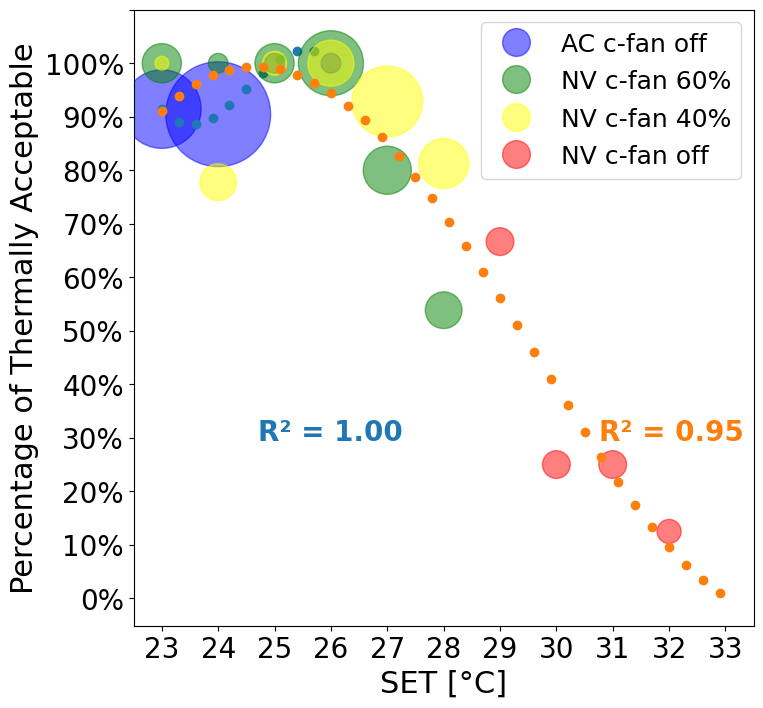

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.lines import Line2D
from sklearn.pipeline import Pipeline

plt.figure(figsize=(8, 8))

colorMap = {
    'AC':"#0000FF"
}
labels = {
    'AC':"AC c-fan off"
}

custom_handles = []
custom_labels = []
# bubble plot process
for thermalType in colorMap.keys():
    dataFilteredByThermalType = data[data['Thermal']==thermalType].copy()
    Y = dataFilteredByThermalType['ThermalAcceptability'].copy()
    x_list = np.floor(dataFilteredByThermalType['SET']).astype(int).values.copy()
    coordinates = list(zip(x_list, Y))
    counts = Counter(coordinates)
    # Extract x, y, and size data
    x = [coord[0] for coord in counts.keys()]
    y = [coord[1] for coord in counts.keys()]
    sizes = [count for count in counts.values()]

    # Sample DataFrame
    dict_data = {
        'x': x,
        'y': y,
        'size': sizes
    }
    df = pd.DataFrame(dict_data)

    # Define custom aggregation function
    def custom_agg(x):
        return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})
    
    # Grouping by 'x' and aggregating y and size
    grouped_df = df.groupby('x').apply(custom_agg).reset_index()
    # Plotting the bubble plot
    plt.scatter(grouped_df['x'], grouped_df['y'], s=grouped_df['size'], alpha=0.5, c=colorMap[thermalType])
    custom_handles.append(
       Line2D([0], [0], marker='o', color=colorMap[thermalType], markersize=20, alpha=0.5, linewidth=0)
    )
    custom_labels.append(
       labels[thermalType]
    )


Y = data[data['Thermal']=='AC']['ThermalAcceptability'].copy()
X = np.floor(data[data['Thermal']=='AC']['SET']).astype(int).copy()

coordinates = list(zip(X, Y))
counts = Counter(coordinates)
# Extract x, y, and size data
x = [coord[0] for coord in counts.keys()]
y = [coord[1] for coord in counts.keys()]
sizes = [count for count in counts.values()]

# Sample DataFrame
dict_data = {
    'x': x,
    'y': y,
    'size': sizes
}
df = pd.DataFrame(dict_data)

# Define custom aggregation function
def custom_agg(x):
    return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})

# Grouping by 'x' and aggregating y and size
grouped_df = df.groupby('x').apply(custom_agg).reset_index()

# regression code
poly_features = Pipeline([('poly', PolynomialFeatures(degree=4, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=False))])
poly_features.fit(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))
r_squared = poly_features.score(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))

# Get formula
intercept = poly_features.named_steps['linear'].intercept_
coefficients = poly_features.named_steps['linear'].coef_

# Print R-squared value and formula
print("R-squared:", r_squared)
print("Formula: y =", intercept, "+", coefficients[0][0], "x +", coefficients[0][1], "x^2 +", coefficients[0][2], "x^3 +", coefficients[0][3], "x^4")

# reg plot
x_pred = np.arange(grouped_df.x.min(), grouped_df.x.max(), 0.3)
sc = plt.scatter(x_pred.reshape(-1,1), poly_features.predict(x_pred.reshape(-1,1)))
plt.text(.2, .3, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=20, fontweight='bold',color=sc.get_facecolor())
plt.legend(custom_handles, custom_labels, handleheight=1, fontsize=18)

colorMap = {
    'NV fan 5':"#008000",
    'NV fan 3':"#FFFF00", 
    'NV fan 0':"#FF0000"
}
labels = {
    'NV fan 5':"NV c-fan 60%",
    'NV fan 3':"NV c-fan 40%", 
    'NV fan 0':"NV c-fan off"
}

# custom_handles = []
# custom_labels = []
# bubble plot process
for thermalType in colorMap.keys():
    dataFilteredByThermalType = data[data['Thermal']==thermalType].copy()
    Y = dataFilteredByThermalType['ThermalAcceptability'].copy()
    x_list = np.floor(dataFilteredByThermalType['SET']).astype(int).values.copy()
    coordinates = list(zip(x_list, Y))
    counts = Counter(coordinates)
    # Extract x, y, and size data
    x = [coord[0] for coord in counts.keys()]
    y = [coord[1] for coord in counts.keys()]
    sizes = [count for count in counts.values()]

    # Sample DataFrame
    dict_data = {
        'x': x,
        'y': y,
        'size': sizes
    }
    df = pd.DataFrame(dict_data)

    # Define custom aggregation function
    def custom_agg(x):
        return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})
    
    # Grouping by 'x' and aggregating y and size
    grouped_df = df.groupby('x').apply(custom_agg).reset_index()
    # Plotting the bubble plot
    plt.scatter(grouped_df['x'], grouped_df['y'], s=grouped_df['size'], alpha=0.5, c=colorMap[thermalType])
    custom_handles.append(
       Line2D([0], [0], marker='o', color=colorMap[thermalType], markersize=20, alpha=0.5, linewidth=0)
    )
    custom_labels.append(
       labels[thermalType]
    )


Y = data[data['Thermal']!='AC']['ThermalAcceptability'].copy()
X = np.floor(data[data['Thermal']!='AC']['SET']).astype(int).copy()

coordinates = list(zip(X, Y))
counts = Counter(coordinates)
# Extract x, y, and size data
x = [coord[0] for coord in counts.keys()]
y = [coord[1] for coord in counts.keys()]
sizes = [count for count in counts.values()]

# Sample DataFrame
dict_data = {
    'x': x,
    'y': y,
    'size': sizes
}
df = pd.DataFrame(dict_data)

# Define custom aggregation function
def custom_agg(x):
    return pd.Series({'y': x[x['y']>=3]['size'].sum()/x['size'].sum(), 'size': x[x['y']>=3]['size'].sum()*100})

# Grouping by 'x' and aggregating y and size
grouped_df = df.groupby('x').apply(custom_agg).reset_index()

# regression code
poly_features = Pipeline([('poly', PolynomialFeatures(degree=4, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=False))])
poly_features.fit(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))
r_squared = poly_features.score(grouped_df['x'].values.reshape(-1,1),grouped_df['y'].values.reshape(-1,1))

# Get formula
intercept = poly_features.named_steps['linear'].intercept_
coefficients = poly_features.named_steps['linear'].coef_

# Print R-squared value and formula
print("R-squared:", r_squared)
print("Formula: y =", intercept, "+", coefficients[0][0], "x +", coefficients[0][1], "x^2 +", coefficients[0][2], "x^3 +", coefficients[0][3], "x^4")

# reg plot
x_pred = np.arange(grouped_df.x.min(), grouped_df.x.max(), 0.3)
sc = plt.scatter(x_pred.reshape(-1,1), poly_features.predict(x_pred.reshape(-1,1)))
plt.text(.75, .3, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color=sc.get_facecolor())
plt.legend(custom_handles, custom_labels, handleheight=1, fontsize=18)

plt.xticks(np.arange(data.SET.astype(int).min(), data.SET.max(), 1), fontsize=20)
plt.yticks(np.arange(0, 1.2, 0.1), ['0%','10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%', ''], fontsize=20)
plt.xlabel('SET [°C]', fontsize=22)  # Set x-axis title
plt.ylabel('Percentage of Thermally Acceptable', fontsize=22)  # Set y-axis title

plt.show() 